# Calculate diversity of generations
From paper, page 9:

The diversity is measured using the average overlap of the longest sub-sequence (LCS) among sampled answers:

\begin{equation}
1 - \frac{1}{\binom{M}{2}} \sum_{s \neq s' \in C} \text{ROUGE-L}(s, s') 
\end{equation}

$\binom{M}{2}$ is the number of possible pairs of $s \neq s'$ (order doesn't matter)


In [1]:
import glob
import pickle
from itertools import combinations
from rouge_score import rouge_scorer
import yaml
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from tqdm import tqdm

warnings.simplefilter(action='ignore', category=FutureWarning)

with open("config.yaml", "r") as f:
    config = yaml.safe_load(f)

In [2]:
def diversity(string_list):
    rouge_l_sum = 0
    n_pairs = 0

    for s, s_prime in combinations(string_list, 2):
        rouge_l_sum += scorer.score(s, s_prime)["rougeL"].fmeasure
        n_pairs += 1

    return 1 - rouge_l_sum / n_pairs

In [3]:
def load_pickle_files(folder):
    data_groups = []
    pickle_files = glob.glob(f"{folder}/group*.pkl")
    for pickle_file in pickle_files:
        with open(pickle_file, "rb") as f:
            data_groups.append(pickle.load(f))

    return data_groups

In [4]:
# https://thepythoncode.com/article/calculate-rouge-score-in-python#rouge-l
scorer = rouge_scorer.RougeScorer(["rougeL"], use_stemmer=True)

save_path = config["path_to_saved_generations"]
data_groups = load_pickle_files(save_path)

keys_data = [f"temperature_{temp}" for temp in config["temperatures"]] + [f"beam_{beam}" for beam in config["n_beams"]]
diversity_scores = {k: [] for k in keys_data}

In [5]:
for data in data_groups:
    group_diversity_scores = {k: [] for k in keys_data}
    for question_idx in data.keys():
        for k in keys_data:
            answers = data[question_idx][k]["answers"]
            group_diversity_scores[k].append(diversity(answers))

    # Add mean diversity of group to diversity_scores
    diversity_scores = {k: diversity_scores[k] + [np.mean(group_diversity_scores[k])] for k in keys_data}

In [6]:
# Convert to pandas df
diversity = pd.DataFrame(diversity_scores,
                         index=pd.Index([f"group_{i}" for i in range(len(data_groups))]))
diversity.index.name = "group"
diversity.reset_index(inplace=True)
print("Diversity scores of sampled answers")
diversity

Diversity scores of sampled answers


,group,temperature_0.25,temperature_0.5,temperature_1,temperature_1.5,beam_20
0,group_0,0.369426,0.637823,0.886433,0.956363,0.599882
1,group_1,0.347955,0.618786,0.883092,0.958035,0.611705
2,group_2,0.353941,0.625156,0.885565,0.959431,0.609484
3,group_3,0.356296,0.622342,0.888287,0.961473,0.617475
4,group_4,0.350981,0.605766,0.877252,0.955160,0.611195


**Diversity Scores for multinomial beam sampling:**

Results from the paper:
- Page 15: "Beam search also generates much less diverse samples. We conjecture that multinomial beam search sampling focuses too much on the most likely sequences. The diversity of this beam search corresponds to the lowest temperature result."
- Page 16, Table 4: Multinomial beam search sampling leads to a diversity of answers of $0.258$

This is different to the results I obtain. For me, it is approx. 0.61 (see below). This is more than twice as big. One reason for this could be that I am using 20 beams and take the 10 beams with the highest probability. In the paper they use 5 beams for each answer. In my case, the diversity score of beam sampling is approximately the same diversity score when using a temperature value of 0.5.

In [7]:
np.mean(diversity["beam_20"])

0.6099479605148326

## Visualize results
### Diversity increases with increasing temperature

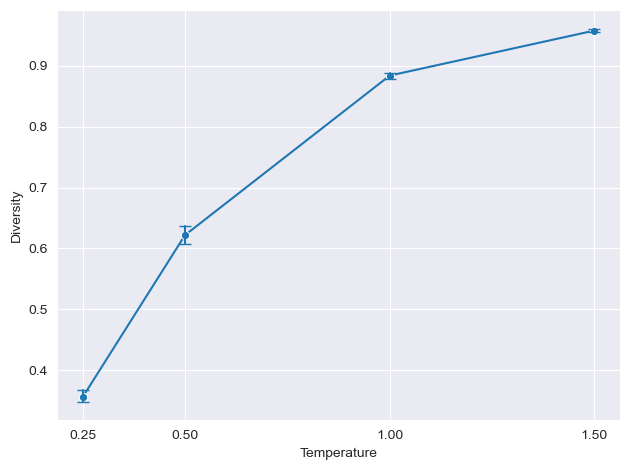

In [9]:
# Preprocessing
diversity_temperatures = diversity.drop(columns=diversity.filter(like="beam_").columns)
diversity_temperatures = pd.melt(diversity_temperatures, id_vars=["group"], value_name="diversity",
                                 var_name="temperature")
diversity_temperatures["group"] = diversity_temperatures["group"].str.replace("group_", "").astype(int)
diversity_temperatures["temperature"] = diversity_temperatures["temperature"].str.replace("temperature_", "").astype(
    float)

# Plot
plt.figure()
sns.lineplot(data=diversity_temperatures, x="temperature", y="diversity", errorbar="pi", estimator="mean", marker="o",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5)
plt.xlabel("Temperature")
plt.ylabel("Diversity")
plt.xticks(config["temperatures"])
plt.tight_layout()
plt.show()

The results are similar to the ones in the paper (see Figure 3). In general, one can see that higher temperatures result in more diversity. In this plot, the diversity scores for the temperatures $0.25$ and $0.5$ are lower than the one in the paper. The reason for this could be the smaller model size. 

### Average correctness of sampled answers
Include the average correctness of sampled answers (also done in the paper, see page 9). I compare the results for ROUGE-L > 0.3 and ROUGE-1 > 0.5 (Reason: see notebook `greedy_answers.ipynb`)

In [11]:
scorer = rouge_scorer.RougeScorer(["rougeL", "rouge1"], use_stemmer=True)
correctness_scores_rouge_1 = {k: [] for k in keys_data}
correctness_scores_rouge_l = {k: [] for k in keys_data}

In [12]:
for data in data_groups:
    group_correctness_scores_rouge_1 = {k: [] for k in keys_data}
    group_correctness_scores_rouge_l = {k: [] for k in keys_data}

    for question_idx in tqdm(data.keys()):
        true_answer = data[question_idx]["true_answer"]

        # Iterate over different temperatures, beam sizes
        for k in keys_data:
            answers = data[question_idx][k]["answers"]
            n_correct_rouge_l = 0
            n_correct_rouge_1 = 0

            for a in answers:
                if scorer.score(a, true_answer)["rougeL"].fmeasure > 0.3:
                    n_correct_rouge_l += 1
                if scorer.score(a, true_answer)["rouge1"].fmeasure > 0.5:
                    n_correct_rouge_1 += 1

            group_correctness_scores_rouge_l[k].append(n_correct_rouge_l / len(answers))
            group_correctness_scores_rouge_1[k].append(n_correct_rouge_1 / len(answers))

    # Add mean diversity of group to diversity_scores
    correctness_scores_rouge_l = {k: correctness_scores_rouge_l[k] + [np.mean(group_correctness_scores_rouge_l[k])] for
                                  k in
                                  keys_data}
    correctness_scores_rouge_1 = {k: correctness_scores_rouge_1[k] + [np.mean(group_correctness_scores_rouge_1[k])] for
                                  k
                                  in
                                  keys_data}

100%|██████████| 1000/1000 [00:13<00:00, 73.87it/s]


In [13]:
# Convert to pandas df
correctness_rouge_l = pd.DataFrame(correctness_scores_rouge_l,
                                   index=pd.Index([f"group_{i}" for i in range(len(data_groups))]))
correctness_rouge_l.index.name = "group"
correctness_rouge_l.reset_index(inplace=True)
print("Average correctness of sampled answers using ROUGE-L > 0.3")
correctness_rouge_l

Average correctness of sampled answers using ROUGE-L > 0.3


,group,temperature_0.25,temperature_0.5,temperature_1,temperature_1.5,beam_20
0,group_0,0.1720,0.1633,0.1098,0.0684,0.1019
1,group_1,0.1928,0.1729,0.1109,0.0652,0.0863
2,group_2,0.1825,0.1610,0.1107,0.0602,0.0906
3,group_3,0.1855,0.1716,0.1079,0.0620,0.0921
4,group_4,0.1823,0.1715,0.1186,0.0689,0.0889


In [14]:
# Convert to pandas df
correctness_rouge_1 = pd.DataFrame(correctness_scores_rouge_1,
                                   index=pd.Index([f"group_{i}" for i in range(len(data_groups))]))
correctness_rouge_1.index.name = "group"
correctness_rouge_1.reset_index(inplace=True)
print("Average correctness of sampled answers using ROUGE-1 > 0.5")
correctness_rouge_1

Average correctness of sampled answers using ROUGE-1 > 0.5


,group,temperature_0.25,temperature_0.5,temperature_1,temperature_1.5,beam_20
0,group_0,0.1294,0.1211,0.0801,0.0415,0.0602
1,group_1,0.1401,0.1260,0.0773,0.0408,0.0410
2,group_2,0.1350,0.1164,0.0771,0.0358,0.0494
3,group_3,0.1291,0.1199,0.0730,0.0362,0.0485
4,group_4,0.1290,0.1204,0.0820,0.0426,0.0449


As a first point you can see that the accuracy when using ROUGE-1 > 0.5 is significantly lower than the one with ROUGE-L > 0.3. The reasons for this (also see `greedy_answers.ipynb`) is that ROUGE-L > 0.3 leads to a high number of false positives. The answers in TriviaQA are quite short and if the generated answer and the true answer share a stop word, the ROUGE-L score is often already greater than 0.3. ROUGE-1 > 0.5 seems to be much more accurate than ROUGE-L > 0.3. As a result, in the plot with diversity and accuracy plotted together (see below), I only plot ROUGE-1 > 0.5.

These average correctness scores are lower than the ones in the paper (Figure 3). This potentially comes from using the OPT model with 1.3B parameters - in the paper they use the one with 30B parameters.

For beam sampling one can see that the average correctness is approx. 0.049 when using ROUGE-1 > 0.5, which is lower than the average correctness for the temperature values 0.25, 0.5 and 1. 

In [15]:
np.mean(correctness_rouge_l["beam_20"]), np.mean(correctness_rouge_1["beam_20"])

(0.09196, 0.048799999999999996)

### Higher temperatures result in less accurate generations

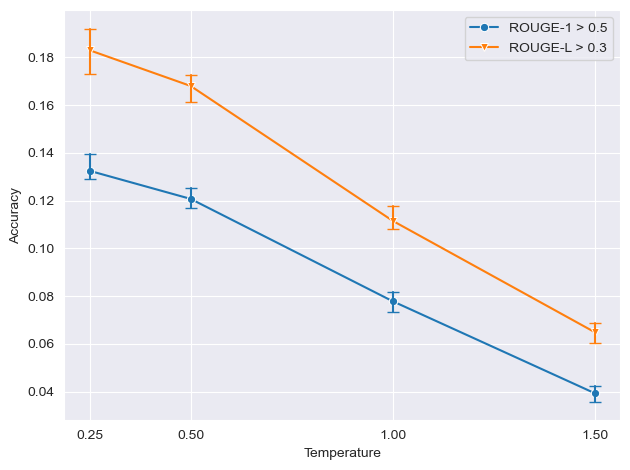

In [19]:
# Preprocessing
correctness_rouge_1_temperatures = correctness_rouge_1.drop(columns=correctness_rouge_1.filter(like="beam_").columns)
correctness_rouge_1_temperatures = pd.melt(correctness_rouge_1_temperatures, id_vars=["group"], value_name="accuracy",
                                           var_name="temperature")
correctness_rouge_1_temperatures["group"] = correctness_rouge_1_temperatures["group"].str.replace("group_", "").astype(
    int)
correctness_rouge_1_temperatures["temperature"] = correctness_rouge_1_temperatures["temperature"].str.replace(
    "temperature_",
    "").astype(
    float)

correctness_rouge_l_temperatures = correctness_rouge_l.drop(columns=correctness_rouge_1.filter(like="beam_").columns)
correctness_rouge_l_temperatures = pd.melt(correctness_rouge_l_temperatures, id_vars=["group"], value_name="accuracy",
                                           var_name="temperature")
correctness_rouge_l_temperatures["group"] = correctness_rouge_l_temperatures["group"].str.replace("group_", "").astype(
    int)
correctness_rouge_l_temperatures["temperature"] = correctness_rouge_l_temperatures["temperature"].str.replace(
    "temperature_",
    "").astype(
    float)

# Plot
plt.figure()
sns.lineplot(data=correctness_rouge_1_temperatures, x="temperature", y="accuracy", errorbar="pi", estimator="mean",
             marker="o",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, label="ROUGE-1 > 0.5")
sns.lineplot(data=correctness_rouge_l_temperatures, x="temperature", y="accuracy", errorbar="pi", estimator="mean",
             marker="v",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, label="ROUGE-L > 0.3")
plt.xlabel("Temperature")
plt.ylabel("Accuracy")
plt.xticks(config["temperatures"])
plt.tight_layout()
plt.show()

This fits to the observations in the paper:

- Page 9, Figure 3: "Higher temperatures result in more diversity but less accurate generations."
- Page 9: "Reducing the temperature improves the average correctness of the answer"

Add the plots to one plot:

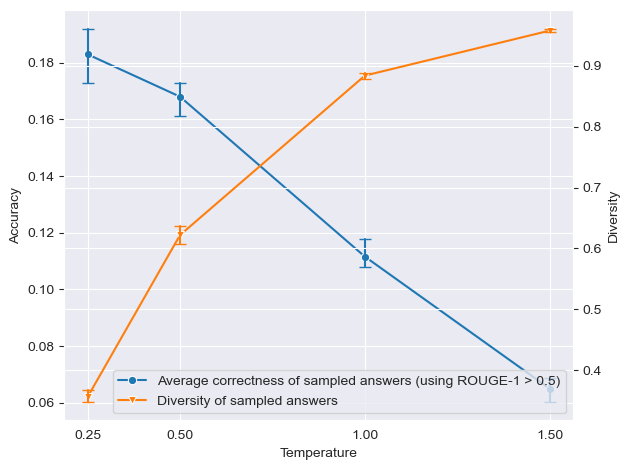

In [21]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

# Accuracy on left y-axis
sns.lineplot(data=correctness_rouge_l_temperatures, x="temperature", y="accuracy", errorbar="pi", estimator="mean",
             marker="o",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, ax=ax1, color='#1f77b4',
             label="Average correctness of sampled answers (using ROUGE-1 > 0.5)")
ax1.set_xlabel("Temperature")
ax1.set_ylabel("Accuracy")
ax1.set_xticks(config["temperatures"])

# Diversity on right y-axis
ax2 = ax1.twinx()
sns.lineplot(data=diversity_temperatures, x="temperature", y="diversity", errorbar="pi", estimator="mean", marker="v",
             err_style="bars", err_kws={"capsize": 4}, linewidth=1.5, ax=ax2, color="#ff7f0e",
             label="Diversity of sampled answers")
ax2.set_ylabel("Diversity")

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines + lines2, labels + labels2)

# Remove other legend 
ax1.get_legend().remove()

plt.tight_layout()
plt.show()